# Setting Environment

In [0]:
from google.colab import drive 

drive.mount('/content/gdrive')

path = './gdrive/My Drive/Colab Demo Data/'

In [0]:
# Check if GPU working

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Deep Learning

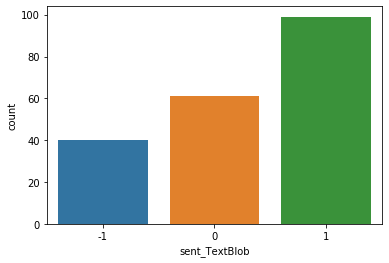

In [0]:
dft = df_tweets_pub
Y_label = 'sent_TextBlob'  #sent_SWN, sent_TextBlob

import seaborn as sns
sns.countplot(x= Y_label, data=dft)

## Pre-process

In [0]:
import nltk
from nltk.corpus import stopwords

from numpy import array

import keras

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [0]:
X=[]
sentences = list(dft['tweets'])

for sen in sentences:
    X.append(sentences)

In [0]:
no_Y = dft[Y_label].nunique()

print(set(dft[Y_label]))
print(no_Y)

{0, 1, -1}
3


In [0]:
# Label Encoding
label_map = {0: 0, -1: -1, 1: 1}

Y = dft[Y_label].map(label_map)
set(Y)

{-1, 0, 1}

In [0]:
# 資料切割：Train & Test

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, Y , test_size=0.3, random_state=320) 

"""
X_train=X_train.drop(columns=[Y_label])
X_test =X_test.drop(columns=[Y_label])

# 查看結果
print(X_train.shape) 
print(X_test.shape)
print(y_train.shape) 
print(y_test.shape)
"""

# 打亂資料集 (增加亂數性，讓模型訓練更好)
X_train, y_train = shuffle(X_train, y_train)


In [0]:
# Keep Label encoding form for Confusion Matrix
y_train_LBE = y_train
y_test_LBE  = y_test

# One-Hot Encoding for Train NN
from keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=no_Y)
y_test  = to_categorical(y_test, num_classes=no_Y)

### Tokenizer

In [0]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [0]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

### Enbedding Layer

In [0]:
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open(path + 'glove6b100dtxt/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [0]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## Build Model

In [0]:
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten

from keras.layers.embeddings import Embedding

### Regularizer

In [0]:
# 設定 regularizer 
''' Import l1,l2 (regularizer) '''
from keras.regularizers import l1, l2, l1_l2

import keras.backend as K
# l1_l2_list = [(0, 0), (0.0005, 0), (0, 0.0005), (0.0005, 0.0005), (0, 0.005)] #@param {type:"raw"}

l1_alpha = 0.0005
l2_alpha = 0.0005

### Model 1: Simple NN

In [0]:
model_NN = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model_NN.add(embedding_layer)
model_NN.add(Flatten())
model_NN.add(Dense(no_Y, activation='sigmoid', kernel_regularizer=l1_l2(l1=l1_alpha, l2=l2_alpha)))

print(model_NN.summary())

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 100)          19200     
_________________________________________________________________
flatten_5 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 3)                 30003     
Total params: 49,203
Trainable params: 30,003
Non-trainable params: 19,200
_________________________________________________________________
None


### Model 2: CNN

In [0]:
from keras.layers import GlobalMaxPooling1D
from keras.layers import Conv1D

model_CNN = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model_CNN.add(embedding_layer)

model_CNN.add(Conv1D(128, 5, activation='relu'))
model_CNN.add(GlobalMaxPooling1D())
model_CNN.add(Dense(no_Y, activation='sigmoid', kernel_regularizer=l1_l2(l1=l1_alpha, l2=l2_alpha)))

print(model_CNN.summary())

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 100, 100)          19200     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 3)                 387       
Total params: 83,715
Trainable params: 64,515
Non-trainable params: 19,200
_________________________________________________________________
None


### Model 3: RNN (LSTM)

In [0]:
from keras.layers import LSTM

model_LSTM = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model_LSTM.add(embedding_layer)
model_LSTM.add(LSTM(128))

model_LSTM.add(Dense(no_Y, activation='sigmoid', kernel_regularizer=l1_l2(l1=l1_alpha, l2=l2_alpha)))

print(model_LSTM.summary())

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 100, 100)          19200     
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_25 (Dense)             (None, 3)                 387       
Total params: 136,835
Trainable params: 117,635
Non-trainable params: 19,200
_________________________________________________________________
None


### Model 4: DNN

In [0]:
model_DNN = Sequential()

# 活化函數清單 acti_list = ['sigmoid', 'relu', 'tanh', 'softsign'] #@param {type:"raw"}

# 加入第一層 hidden layer (128 neurons) 與指定 input 的維度
model_DNN.add(Dense(128, input_dim=X_train.shape[1], kernel_regularizer=l1_l2(l1=l1_alpha, l2=l2_alpha)))
model_DNN.add(Activation('relu'))

# 加入第二層 hidden layer (256 neurons)
model_DNN.add(Dense(256, kernel_regularizer=l1_l2(l1=l1_alpha, l2=l2_alpha)))
model_DNN.add(Activation('relu'))

# 加入第三層 hidden layer (512 neurons)
model_DNN.add(Dense(512, kernel_regularizer=l1_l2(l1=l1_alpha, l2=l2_alpha)))
model_DNN.add(Activation('relu'))

# 加入 output layer (5 neurons)
model_DNN.add(Dense(no_Y, kernel_regularizer=l1_l2(l1=l1_alpha, l2=l2_alpha)))
model_DNN.add(Activation('softmax'))

# 觀察 model summary
print(model_DNN.summary())

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 128)               12928     
_________________________________________________________________
activation_13 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 256)               33024     
_________________________________________________________________
activation_14 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 512)               131584    
_________________________________________________________________
activation_15 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 3)               

## Compiling

In [0]:
# loss_funcs = ['mean_squared_error', 'mean_absolute_error', 'categorical_crossentropy', 'binary_crossentropy']  #@param {type:"raw"}

loss_fun = 'categorical_crossentropy'

In [0]:
from keras.optimizers import SGD, Adam

optim = 'Adam'

# lr(學習率) - 是一種超參數，它控制了我們在大多程度上調整了我們的網路權重。並對損失梯度進行調整。
# momentum - 動量來源於牛頓定律，基本思想是為了找到最優加入“慣性”的影響，當誤差曲面中存在平坦區域，SGD可以更快的學習。
# decay - 該方法是為了提高SGD尋優能力，具體就是每次迭代的時候減少學習率的大小。

# https://keras.io/optimizers/

# Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# SGD(lr=10e-3, momentum=0.0, decay=0.0, nesterov=False)
# Adagrad(lr=0.01, epsilon=None, decay=0.0)
# RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
# Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
# Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
# Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)

In [0]:
CandidateModel = model_DNN  # model_NN, model_CNN, model_LSTM, model_DNN

CandidateModel.compile(loss=loss_fun,
                       optimizer=optim,
                       metrics=['accuracy'])

## Training

In [0]:
# 設定 batch_size，訓練迭代輪次(回合數) epochs
batch_size = 64 # 1個mini-batch有n筆資料
epochs = 20

# 訓練開始
import time
start = time.process_time()

fitting_history = CandidateModel.fit(X_train, y_train, 
                                     batch_size=batch_size, 
                                     epochs=epochs, 
                                     verbose=1,
                                     shuffle=True, 
                                     validation_split=0.3)

# 訓練結束
end = time.process_time()
print("訓練時間：%.3fs 秒" % (end - start))

# 測試結果
predict =CandidateModel.predict_classes(X_test)  # 預測標籤結果
predict_cross =CandidateModel.predict(X_test)    # 每個標籤的預測機率

## Evaluation

In [0]:
loss, accuracy = CandidateModel.evaluate(X_test, y_test, verbose=1)

print("\nLoss: %.3f, Accuracy: %.2f%%" % (loss, accuracy*100))

#######################

loss     = fitting_history.history.get('loss')      # 取出訓練完成後loss的訓練數據
acc      = fitting_history.history.get('acc')       # 取出訓練完成後accuracy的訓練數據
val_loss = fitting_history.history.get('val_loss')  # 取出訓練完成後val_loss的訓練數據
val_acc  = fitting_history.history.get('val_acc')   # 取出訓練完成後val_accuracy的訓練數據

from pylab import rcParams
rcParams['figure.figsize'] = 10, 7

''' Visualize the loss and accuracy of both models'''
plt.figure(0)
plt.subplot(121)

plt.plot(range(len(loss)), loss, label='Training loss')
plt.plot(range(len(val_loss)), val_loss, label='validation loss')
plt.title('Loss')
plt.legend(loc='upper right')

plt.subplot(122)

plt.plot(range(len(acc)), acc, label='Training accuracy')
plt.plot(range(len(val_acc)), val_acc, label='validation accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [0]:
## 製作 Confusion Matrix圖表來評估模型

confusion_matrix = metrics.confusion_matrix(y_true=y_test_LBE, y_pred=predict, labels=[-1,0,1])

cm =pd.DataFrame(confusion_matrix , index = ['-1', '0', '1'], columns = [ '-1', '0', '1'])
sns.heatmap(cm, annot = True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Accuracy = confusion_matrix.trace() / confusion_matrix.sum()
MissClass = 1 - Accuracy

print("Accuracy : %0.5f" % Accuracy)
print("MissClass: %0.5f" % MissClass)


### Save Model

In [0]:
# 儲存模型

ymd = datetime.now().strftime("%Y%m%d%H%M")
AC = Accuracy.astype('str')

dump(m1, path + 'm1-'+ymd+'XGB'+ AC +'.joblib')

# Scoring

In [0]:

instance = 'I believe that Python 3.1 will print them nicer by default, without any code changing. But that is useless if you use any extensions that havent been updated to work with Python 3.1'

instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

predict_p = CandidateModel.predict(instance)
predict_c = CandidateModel.predict_classes(instance)  # 預測標籤結果

print(predict_p)
print(predict_c)

if predict_c[0]==1:
    print(' Positive')
elif predict_c[0]==-1:
    print(' Negative')
else:
    print(' Nature')


[[0.48823264 0.5123518  0.4875249 ]]
[1]
 Positive
